## Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from google.colab import files
import pickle
import os
import json
from google.colab import drive
warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [22]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
from dotenv import load_dotenv
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
project_config['STOCKS'] = project_config['STOCKS'].split()
project_config['TKL'] = project_config['STOCKS'][0]

# Load dataset file of current TKL

In [24]:
print(f"Loading dataset for {project_config['TKL']} .....\n")

DATASET = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
df_all = pd.read_csv(DATASET, index_col=False)
df_all = df_all.drop(columns=["Unnamed: 0"])

cols_orig = [col for col in df_all.columns if col.endswith('_orig')]
cols_normalized = [col for col in df_all.columns if not col.endswith('_orig')]

df = df_all[cols_normalized]
df_orig = df_all[['Date'] + cols_orig]

print(f"\ndf for training")
print(f"-----------------")
display(df.tail(1))

print(f"\ndf for visualization")
print(f"----------------------")
display(df_orig.tail(1))

Loading dataset for AAPL .....


df for training
-----------------


,Date,y_next,y,y_mean_22,y_min_5,y_diff_5,y_min_66,y_std_5,y_diff_10,y_diff_22,y_mean_66,y_mean_5,NASDAQ,y_pct_5,y_min_22,Oil
4822,2025-12-16,0.949444,0.959203,0.964532,0.957441,-0.009054,0.824836,0.007808,-0.040797,0.005848,0.921906,0.966785,0.96267,-0.009351,0.92975,0.507872



df for visualization
----------------------


,Date,y_orig,y_mean_22_orig,y_min_5_orig,y_diff_5_orig,y_min_66_orig,y_std_5_orig,y_diff_10_orig,y_diff_22_orig,y_mean_66_orig,y_mean_5_orig,NASDAQ_orig,y_pct_5_orig,y_min_22_orig,Oil_orig,y_next_orig
4822,2025-12-16,274.609985,276.122726,274.109985,-2.570007,236.470764,2.216349,-11.580017,1.659973,264.023396,276.761993,23111.460938,-0.009272,266.25,55.27,271.839996


In [25]:
from sklearn.preprocessing import MinMaxScaler

X_cols_full = [col for col in df.columns if col not in ['Date','y_next']]
X_cols_exho = [col for col in df.columns if '_' not in col and col != 'Date']
X_cols_tkl  = ['y']
y_col       = ['y_next']

y_scaler = MinMaxScaler()
y_scaler.fit(df_orig[['y_next_orig']])

MinMaxScaler()

In [26]:
def make_datasets(df, X_cols, y_col):

    LOOK_BACK_DAYS = int(project_config['LOOK_BACK_DAYS'])

    X, y = [], []

    for i in range(LOOK_BACK_DAYS, len(df)):
        X.append(df.loc[i-LOOK_BACK_DAYS:i-1, X_cols].values)
        y.append(df.loc[i, y_col].values[0])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    dates = pd.to_datetime(df['Date'])
    dates_test = dates[-len(y_test):].values

    return X_train, X_test, y_train, y_test, dates_test

In [27]:
def train_predict(X_train, X_test, y_train, y_test, features, model_name, epochs=0, batch_size=0):

  from tensorflow.keras.models import Sequential, Model
  from tensorflow.keras.layers import LSTM, Dense, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Concatenate

  epochs = int(project_config['TRAIN_EPOCS']) if epochs == 0 else epochs
  batch_size = int(project_config['TRAIN_BATCH_SIZE']) if batch_size == 0 else batch_size

  if model_name == 'Parallel.LSTM.GRU':
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))
    lstm_branch = LSTM(units=50, return_sequences=False)(input_layer)
    gru_branch = GRU(units=50, return_sequences=False)(input_layer)
    merged = Concatenate()([lstm_branch, gru_branch])
    dropout = Dropout(0.1, name='dropout_layer')(merged)
    output_layer = Dense(1, activation='sigmoid')(dropout)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')

  if model_name == 'Cascase.CNN.GRU':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        GRU(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
  ])
    model.compile(optimizer='adam', loss='mse')


  if model_name == 'Cascase.CNN.LSTM':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
  ])
    model.compile(optimizer='adam', loss='mse')


  if model_name == 'CNN':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(1)
  ])
    model.compile(optimizer='adam', loss='mse')


  if model_name == 'LSTM':
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
        LSTM(10),
        Dense(1)
  ])
    model.compile(optimizer='adam', loss='mse')


  if model_name == 'GRU':
    model = Sequential([
      GRU(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
      GRU(10),
      Dense(1)
  ])
    model.compile(optimizer='adam', loss='mse')



  if model_name == 'XGBoost':
    from xgboost import XGBRegressor
    model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

  print("\n=====================================================================\n")
  print(f"TKL: {project_config['TKL']}")
  print(f"Model: {model_name}")
  print(f"Features: {features}")
  #model.summary()

  if model_name == 'XGBoost':
    # Reshape X_train and X_test for XGBoost
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    model.fit(X_train_reshaped, y_train)
  else:
    model.fit(X_train, y_train,
              epochs=int(project_config['TRAIN_EPOCS']),
              batch_size=int(project_config['TRAIN_BATCH_SIZE']),
              validation_data=(X_test, y_test),
              verbose=1)

  if model_name == 'XGBoost':
    pred = model.predict(X_test_reshaped)
  else:
    pred = model.predict(X_test)

  unscaled_prediction = y_scaler.inverse_transform(pred.reshape(-1, 1))
  unscaled_y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))

  from sklearn.metrics import mean_absolute_error
  mae = mean_absolute_error(unscaled_y_test, unscaled_prediction)

  from sklearn.metrics import r2_score
  r2 = r2_score(unscaled_y_test, unscaled_prediction)

  print(f"TKL: {project_config['TKL']}")
  print(f"Model: {model_name}")
  print(f"Features: {features}")
  print(f"MAE: {mae:.4f}")
  print(f"R²: {r2:.4f}")

  return unscaled_prediction, unscaled_y_test, model

In [28]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def race_models(tkl, models_to_try):

  results_df = pd.DataFrame(columns=[ "model_name", "X_cols",  "prediction", "mae", "r2", "model" ])

  for X_cols in [X_cols_full, X_cols_exho, X_cols_tkl]:

    X_train, X_test, y_train, y_test, dates_test = make_datasets(df, X_cols, y_col)

    if 'XGBoost' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="XGBoost")
      results_df.loc[len(results_df)] = {
        "model_name": "XGBoost",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'Parallel.LSTM.GRU' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Parallel.LSTM.GRU")
      results_df.loc[len(results_df)] = {
        "model_name": "Parallel.LSTM.GRU",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'Cascase.CNN.GRU' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Cascase.CNN.GRU")
      results_df.loc[len(results_df)] = {
        "model_name": "Cascase.CNN.GRU",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'Cascase.CNN.LSTM' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Cascase.CNN.LSTM")
      results_df.loc[len(results_df)] = {
        "model_name": "Cascase.CNN.LSTM",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'CNN' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="CNN")
      results_df.loc[len(results_df)] = {
        "model_name": "CNN",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'GRU' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="GRU")
      results_df.loc[len(results_df)] = {
        "model_name": "GRU",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
      }

    if 'LSTM' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="LSTM")
      results_df.loc[len(results_df)] = {
        "model_name": "LSTM",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
      }

  return results_df, dates_test, unscaled_y_test

In [29]:
def plot_results(results_df, dates_test, unscaled_y_test):

  import matplotlib.dates as mdates # Added import

  for model_name in results_df.model_name.unique():
    plt.figure(figsize=(10,6))
    plt.title(f"{project_config['TKL']} {model_name}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual", linewidth=2, color='black')

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.model_name == model_name].iterrows():
      plt.plot(dates_test, entry.prediction, label=f"features: {entry.X_cols}", linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    image_name = f"{os.getenv('PROJECT_PATH')}{project_config['images_directory']}{project_config['TKL']}.{model_name}.png"
    plt.savefig(image_name, dpi=300, bbox_inches="tight")
    plt.show()

  # Convert lists in 'X_cols' to tuples for unique identification
  # This is necessary because lists are unhashable, causing TypeError with .unique()
  results_df['X_cols_tuple'] = results_df['X_cols'].apply(tuple)

  for features_tuple in results_df.X_cols_tuple.unique():
    plt.figure(figsize=(10,6))
    # Convert tuple back to list for display purposes in the title
    features = list(features_tuple)
    plt.title(f"{project_config['TKL']} {features}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual", linewidth=2, color='black')

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.X_cols_tuple == features_tuple].iterrows():
      plt.plot(dates_test, entry.prediction, label=f":{entry.model_name}", linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    image_name = f"{os.getenv('PROJECT_PATH')}{project_config['images_directory']}{project_config['TKL']}.{features}.png"
    plt.savefig(image_name, dpi=300, bbox_inches="tight")
    plt.show()



TKL: AAPL
Model: XGBoost
Features: ['y', 'y_mean_22', 'y_min_5', 'y_diff_5', 'y_min_66', 'y_std_5', 'y_diff_10', 'y_diff_22', 'y_mean_66', 'y_mean_5', 'NASDAQ', 'y_pct_5', 'y_min_22', 'Oil']
TKL: AAPL
Model: XGBoost
Features: ['y', 'y_mean_22', 'y_min_5', 'y_diff_5', 'y_min_66', 'y_std_5', 'y_diff_10', 'y_diff_22', 'y_mean_66', 'y_mean_5', 'NASDAQ', 'y_pct_5', 'y_min_22', 'Oil']
MAE: 33.4222
R²: -0.4230


TKL: AAPL
Model: Parallel.LSTM.GRU
Features: ['y', 'y_mean_22', 'y_min_5', 'y_diff_5', 'y_min_66', 'y_std_5', 'y_diff_10', 'y_diff_22', 'y_mean_66', 'y_mean_5', 'NASDAQ', 'y_pct_5', 'y_min_22', 'Oil']
Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0581 - val_loss: 0.0078
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 5.5676e-04 - val_loss: 0.0037
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 4.2425e-04 - val_loss: 0.0032
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 3.8644e-04 - val_loss: 0.0047
Epoch 5/15
119/119 ━━━━━━━

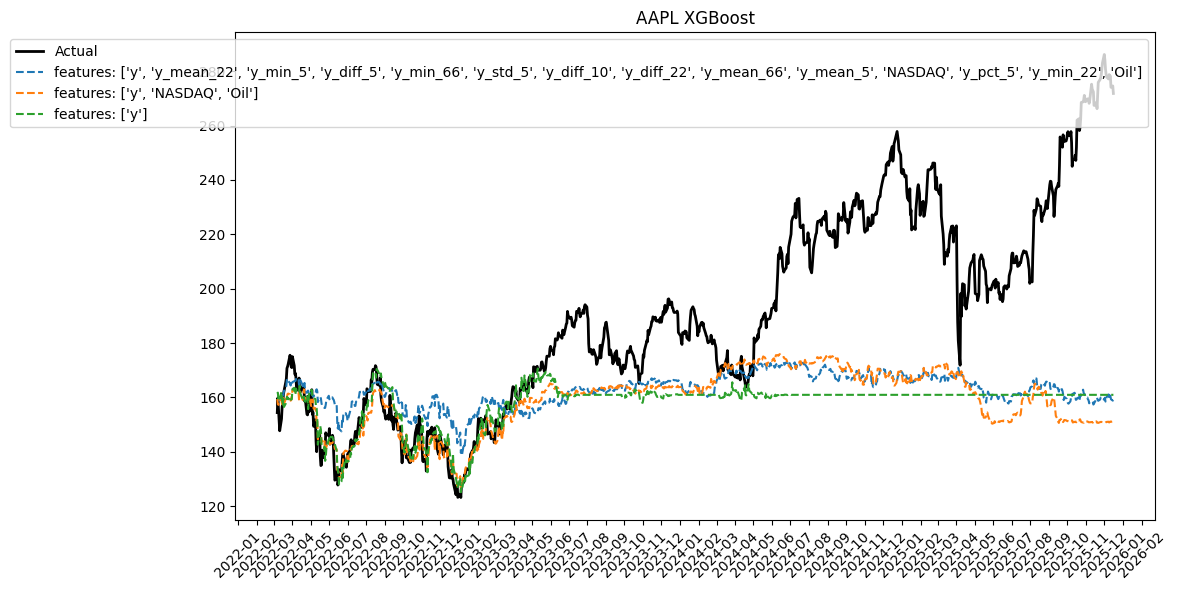

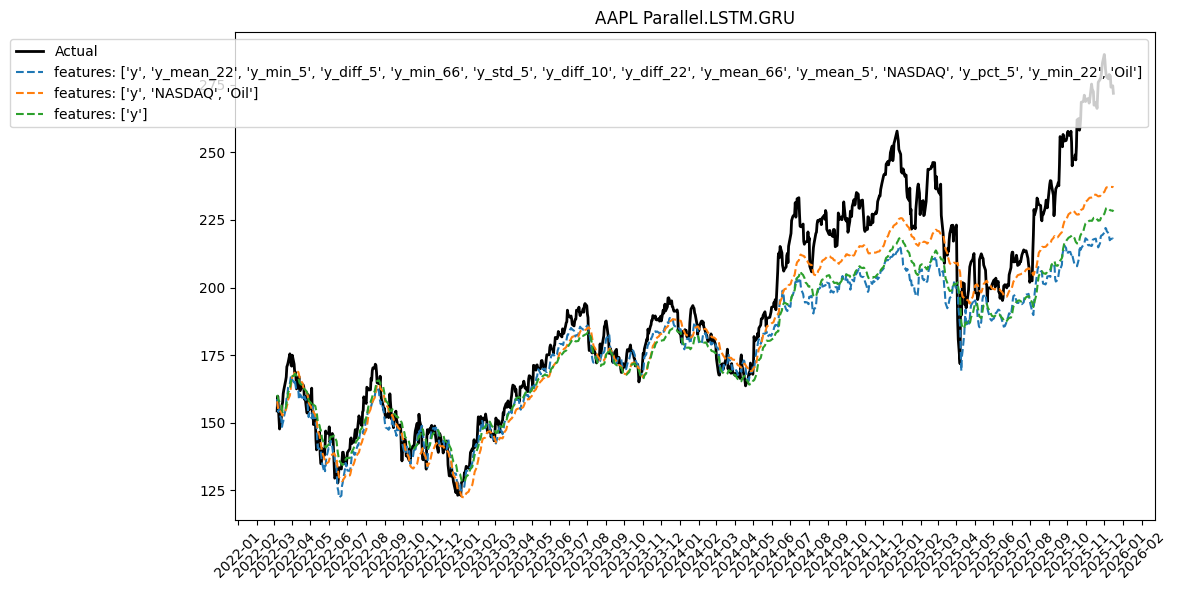

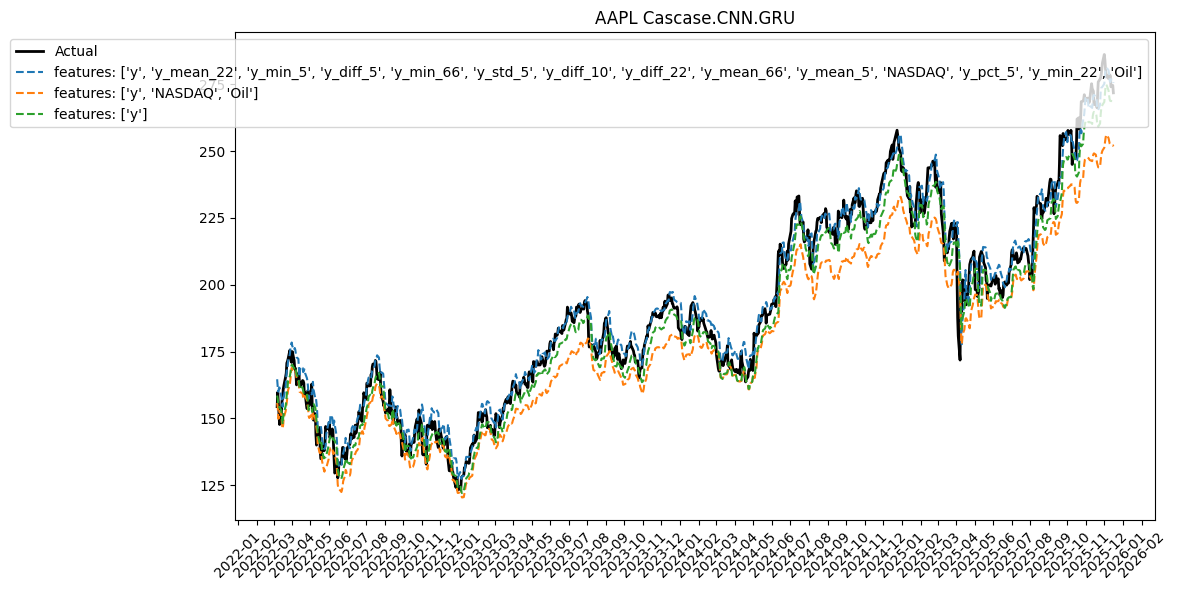

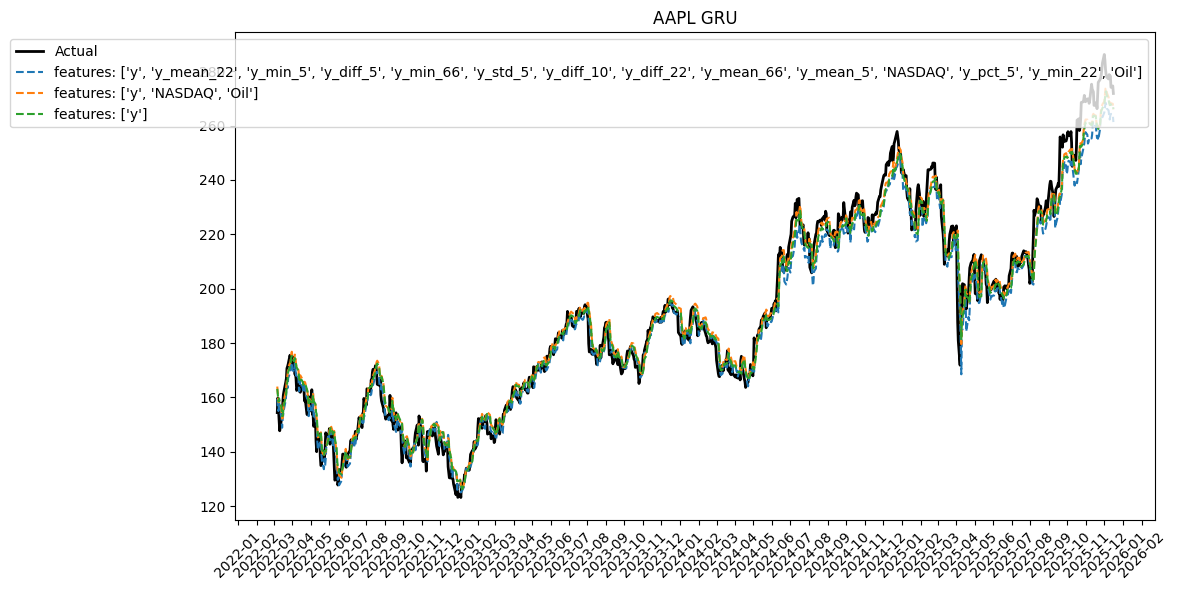

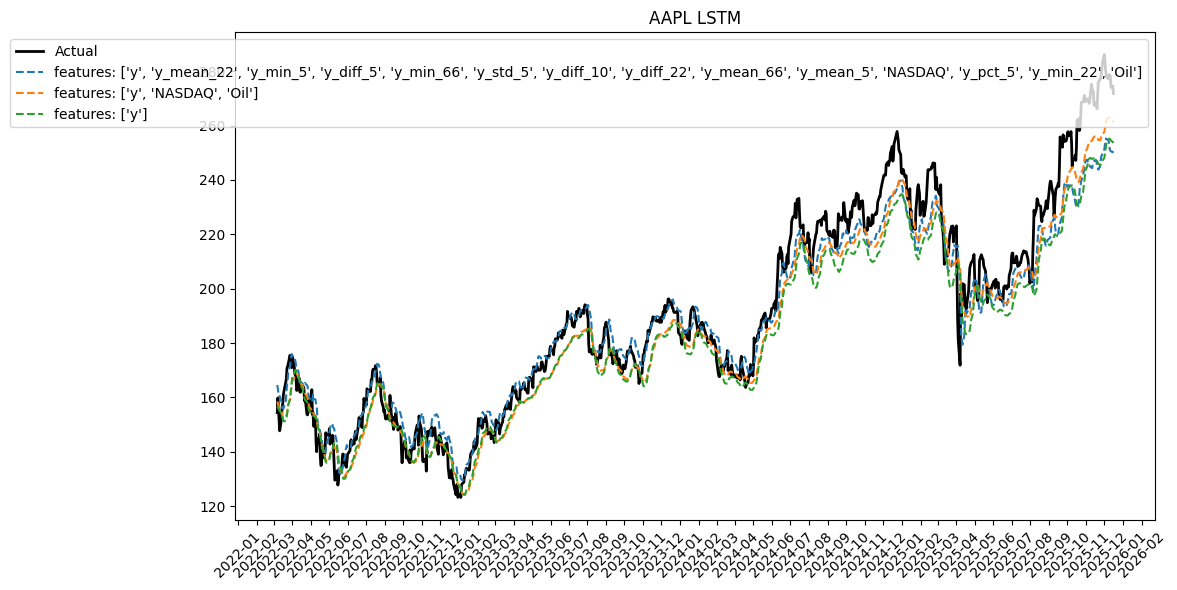

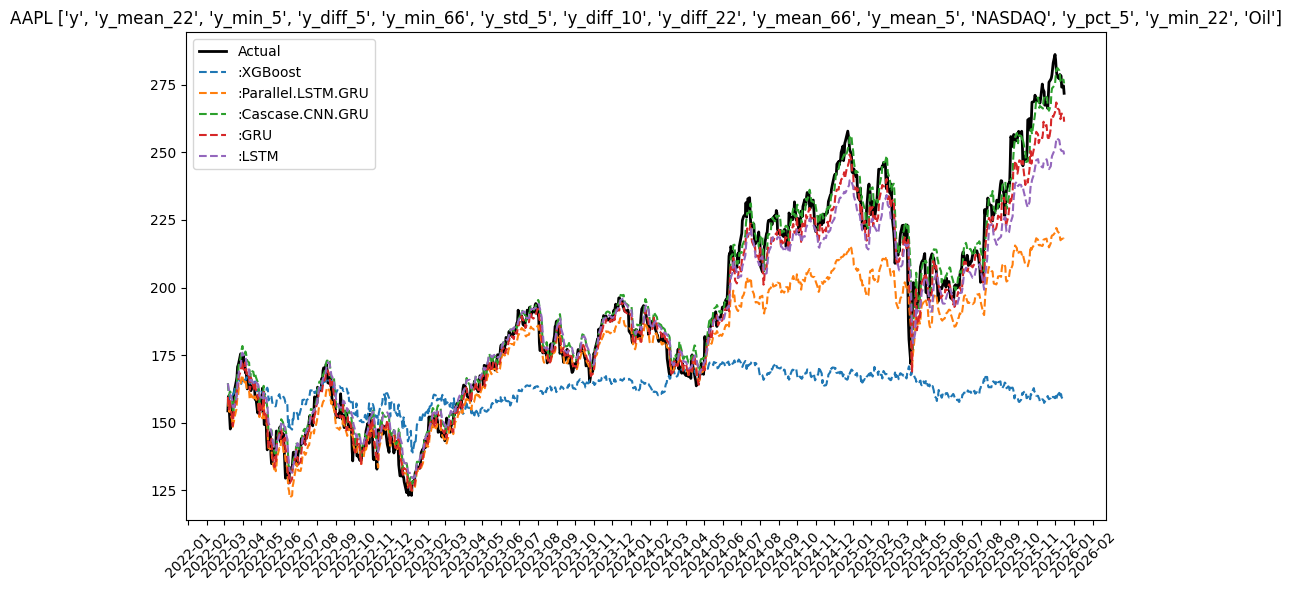

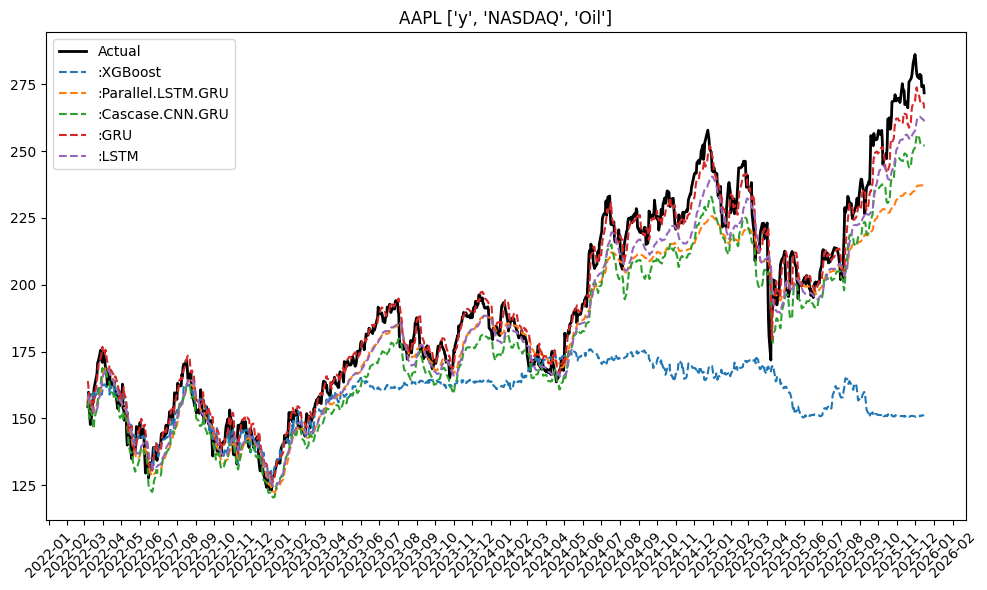

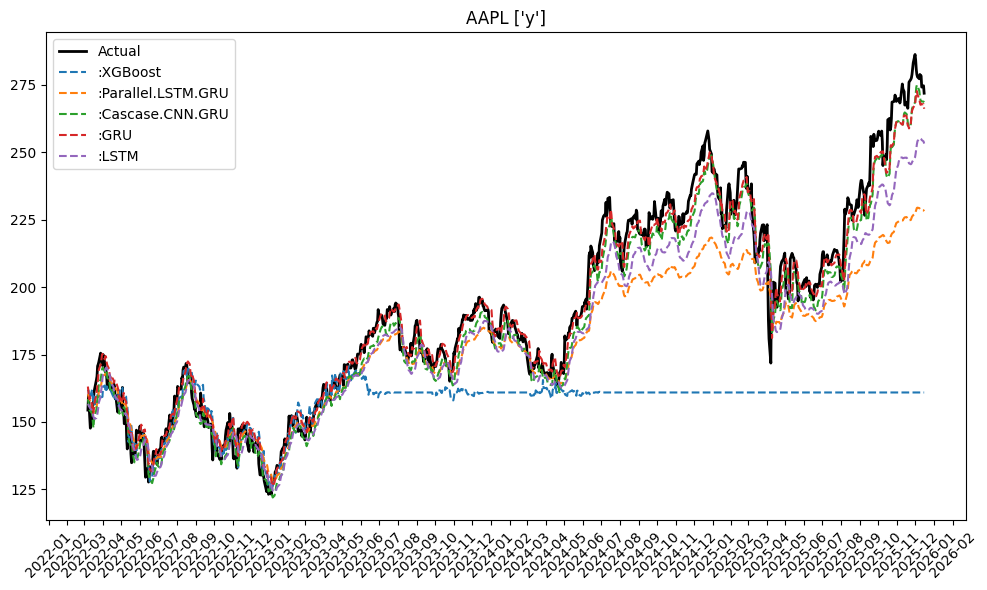

AND THE WINNER for AAPL IS ...


,model_name,X_cols,mae,r2
8,GRU,"[y, NASDAQ, Oil]",4.273900,0.976299
2,Cascase.CNN.GRU,"[y, y_mean_22, y_min_5, y_diff_5, y_min_66, y_...",4.414252,0.974294
13,GRU,[y],4.458424,0.974433
3,GRU,"[y, y_mean_22, y_min_5, y_diff_5, y_min_66, y_...",4.869215,0.968968
12,Cascase.CNN.GRU,[y],6.065859,0.959797
4,LSTM,"[y, y_mean_22, y_min_5, y_diff_5, y_min_66, y_...",6.998099,0.932177
9,LSTM,"[y, NASDAQ, Oil]",7.900236,0.930695
14,LSTM,[y],9.888878,0.889722
6,Parallel.LSTM.GRU,"[y, NASDAQ, Oil]",10.155708,0.863516
7,Cascase.CNN.GRU,"[y, NASDAQ, Oil]",11.319840,0.873574


In [30]:
results_df, dates_test, unscaled_y_test = race_models(project_config['TKL'], project_config['RACING_MODELS'].split())
plot_results(results_df, dates_test, unscaled_y_test)

print(f"AND THE WINNER for {project_config['TKL']} IS ...")
display(results_df[['model_name', 'X_cols', 'mae', 'r2']].sort_values(by='mae', ascending=True))

winning_model = results_df.sort_values(by='mae', ascending=True).iloc[0].model
winning_model_name = results_df.sort_values(by='mae', ascending=True).iloc[0].model_name
winning_model_features = results_df.sort_values(by='mae', ascending=True).iloc[0].X_cols

model_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.model.{winning_model_name}.{winning_model_features}.keras"
df_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df.pkl"
df_orig_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df_orig.pkl"

winning_model.save(model_path)
df[ ['Date','y_next']+winning_model_features ].to_pickle(df_path)
df_orig[ ['Date','y_next_orig'] + [f'{feat}_orig' for feat in winning_model_features] ].to_pickle(df_orig_path)